In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('media.csv', index_col=['date'])
prices.head(10)

ZEEL.NS       PVR.NS     SUNTV.NS  SAREGAMA.NS  TV18BRDCST.NS  \
date                                                                           
01-01-2018  579.200012  1423.750000   998.000000   814.650024      60.700001   
02-01-2018  578.150024  1402.800049   995.200012   792.799988      59.950001   
03-01-2018  579.750000  1401.800049  1004.700012   853.400024      60.500000   
04-01-2018  580.000000  1399.000000  1028.199951   840.250000      60.000000   
05-01-2018  586.849976  1419.000000  1037.949951   832.700012      63.599998   
08-01-2018  593.900024  1460.199951  1044.449951   816.549988      64.250000   
09-01-2018  580.049988  1486.800049  1032.750000   853.700012      62.650002   
10-01-2018  580.500000  1469.000000  1022.150024   829.250000      62.099998   
11-01-2018  580.000000  1460.750000  1043.599976   828.900024      61.900002   
12-01-2018  591.000000  1463.150024  1077.099976   840.000000      66.050003   

            INOXLEISUR.NS  DISHTV.NS  NETWORK18.NS  HATHWAY.NS  
date                                                            
01-01-2018     287.200012  81.699997     59.849998   39.599998  
02-01-2018     280.850006  85.000000     58.950001   39.450001  
03-01-2018     281.000000  85.050003     58.849998   39.799999  
04-01-2018     281.750000  84.550003     60.250000   39.750000  
05-01-2018     287.850006  84.650002     60.599998   40.000000  
08-01-2018     290.799988  85.449997     61.000000   39.799999  
09-01-2018     294.399994  86.199997     60.200001   39.200001  
10-01-2018     287.000000  84.699997     59.099998   39.099998  
11-01-2018     289.000000  83.750000     60.349998   40.299999  
12-01-2018     285.950012  78.099998     62.349998   40.599998

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

ZEEL.NS       PVR.NS    SUNTV.NS  SAREGAMA.NS  TV18BRDCST.NS  \
date                                                                          
01-01-2018  579.200012  1423.750000  998.000000   814.650024      60.700001   
02-01-2018  578.150024  1402.800049  995.200012   792.799988      59.950001   
30-12-2020  219.149994  1290.000000  480.500000   814.799988      31.049999   
31-12-2020  223.500000  1320.199951  480.750000   835.450012      30.900000   

            INOXLEISUR.NS  DISHTV.NS  NETWORK18.NS  HATHWAY.NS  
date                                                            
01-01-2018     287.200012  81.699997     59.849998   39.599998  
02-01-2018     280.850006  85.000000     58.950001   39.450001  
30-12-2020     280.750000  13.350000     36.150002   32.700001  
31-12-2020     282.299988  13.400000     35.900002   33.150002

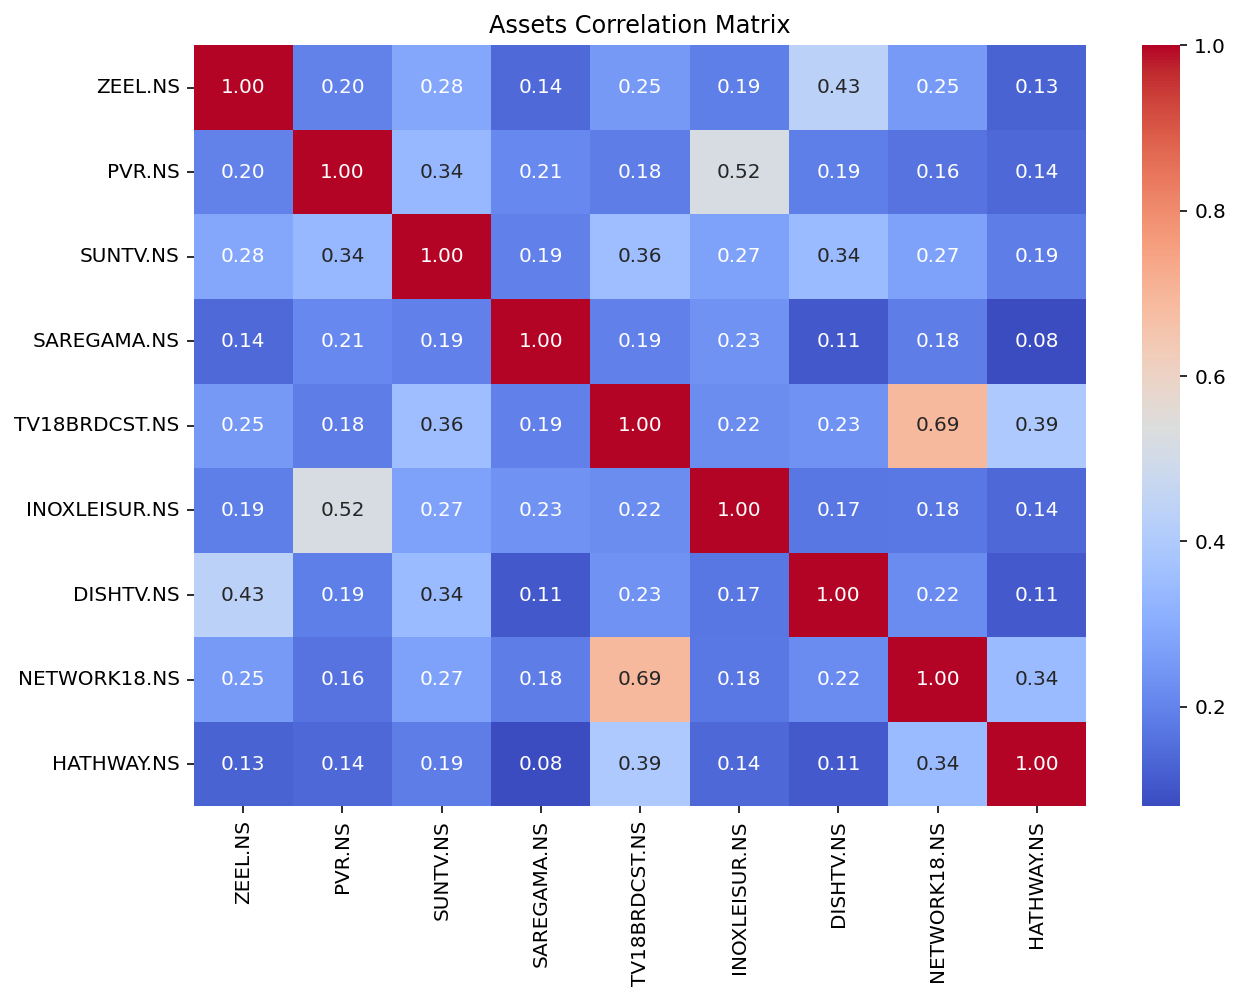

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('SUNTV.NS', 'DISHTV.NS')]


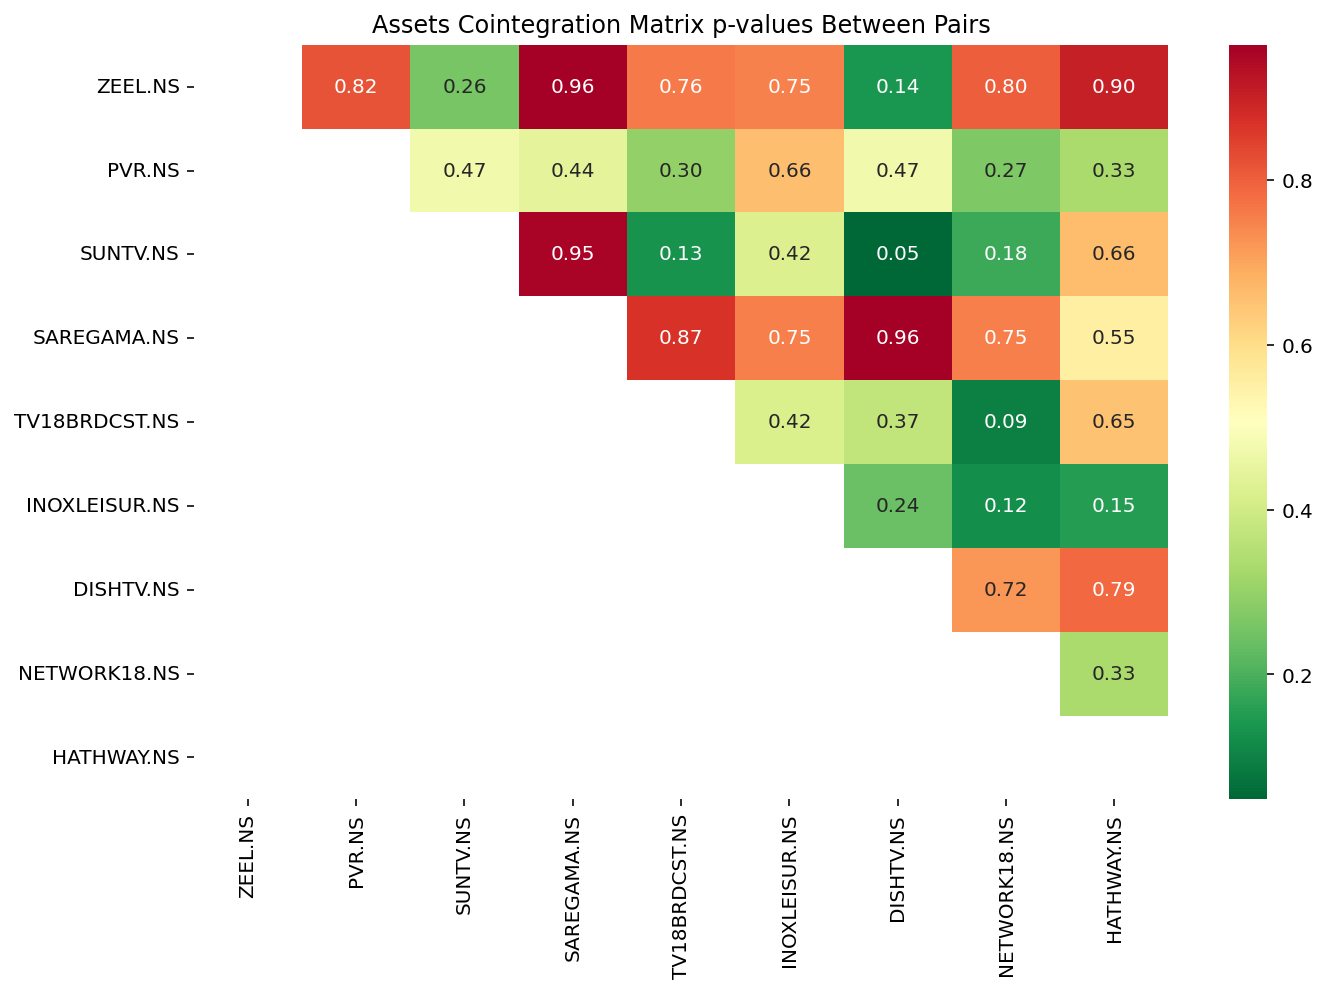

In [7]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [8]:
# final pair to test strategy
asset1 = 'SUNTV.NS'
asset2 = 'DISHTV.NS'

In [9]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

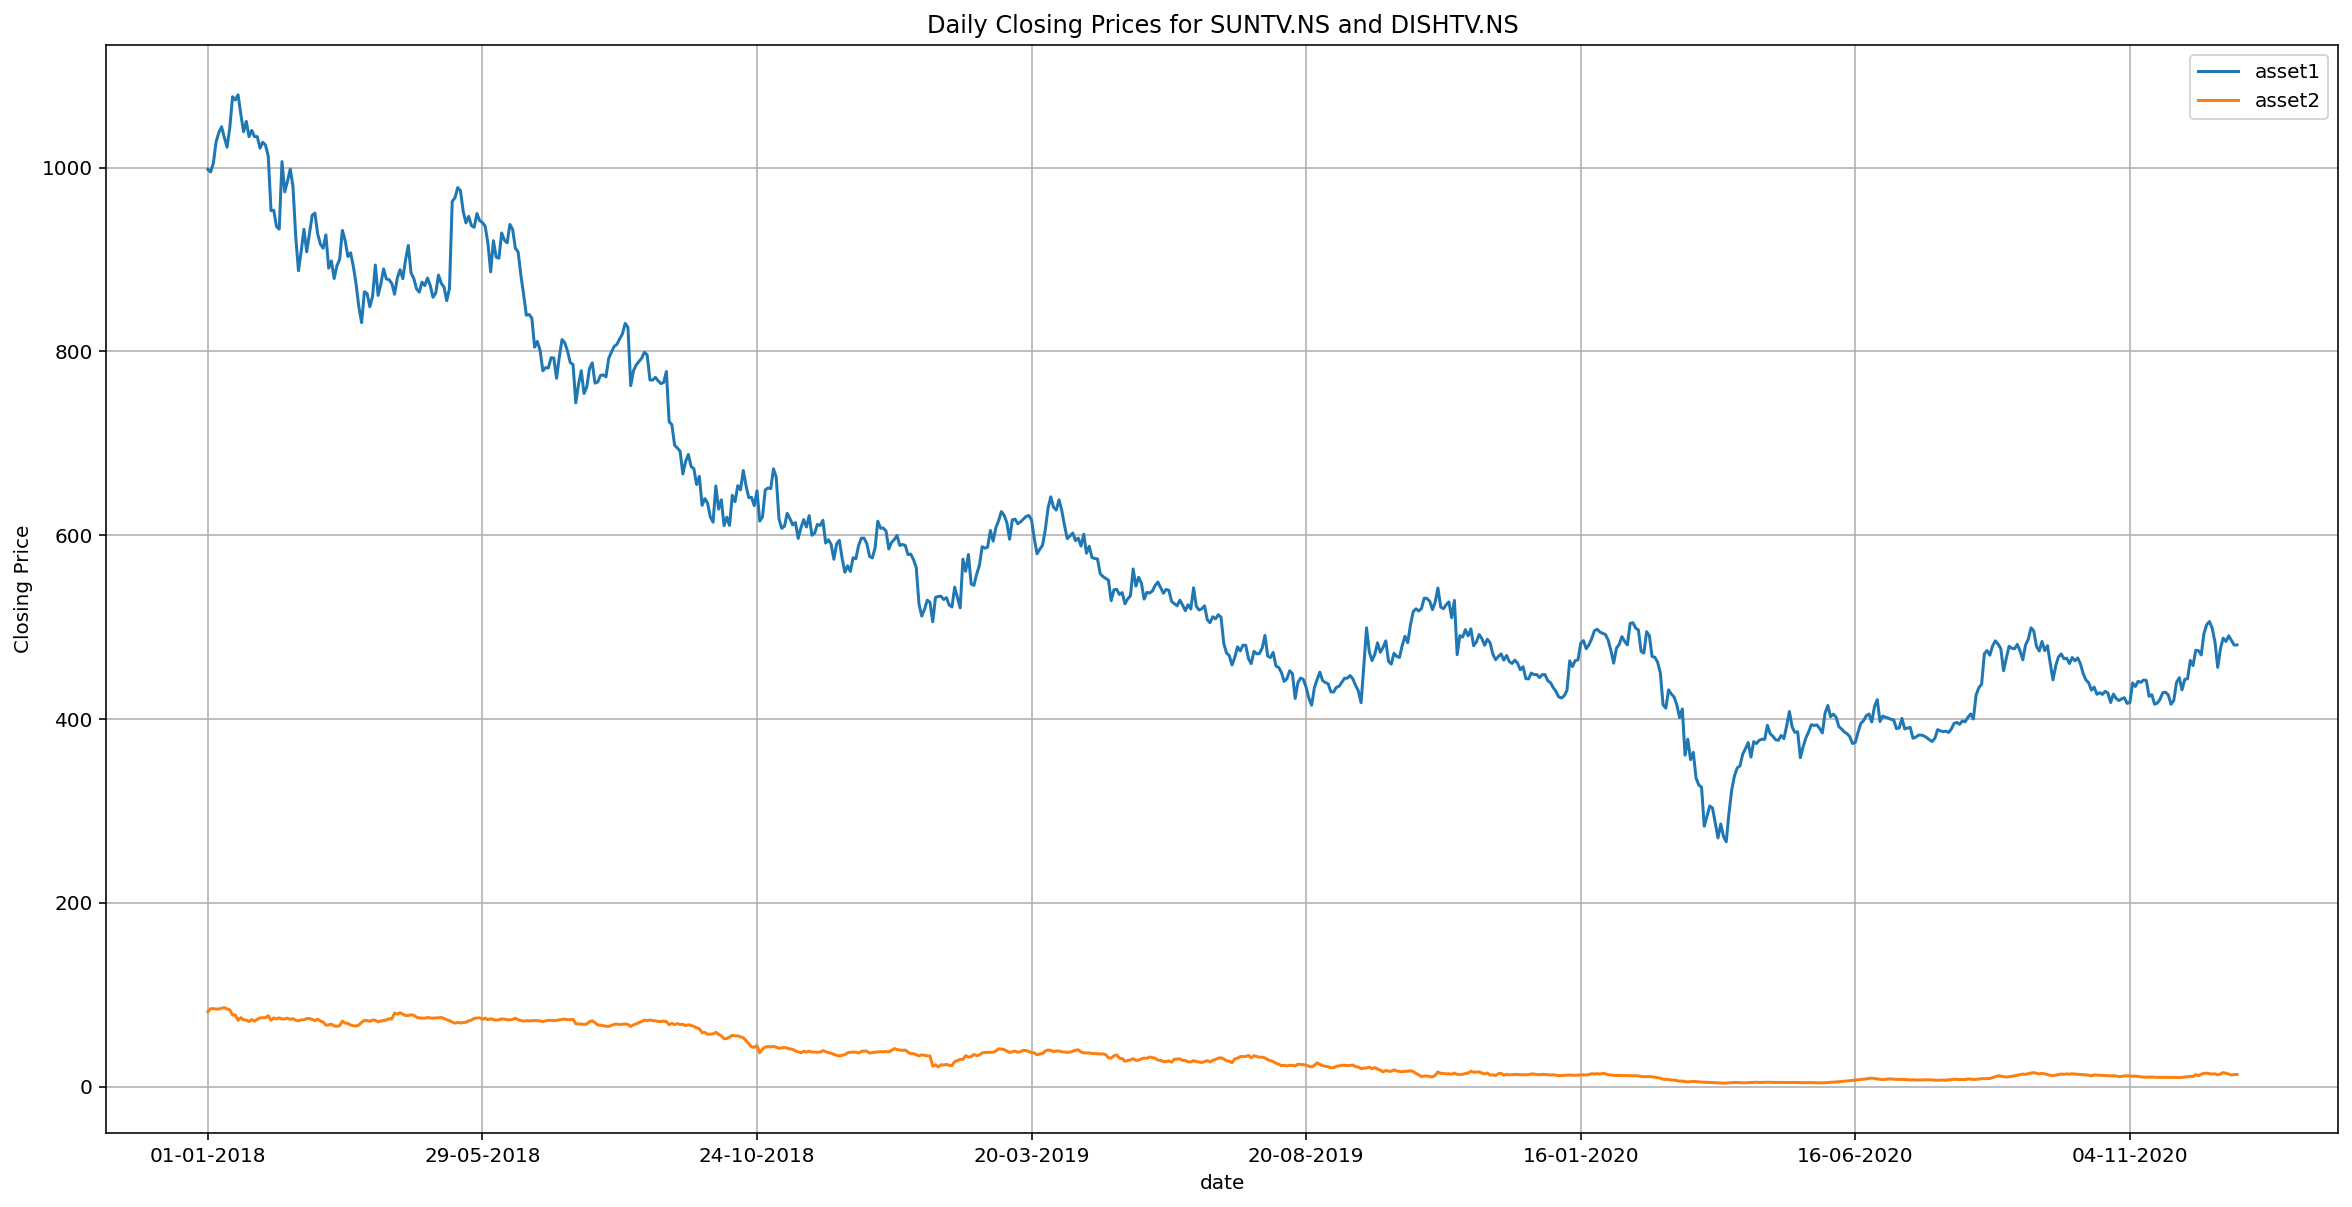

In [10]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(20, 10), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
ax.grid(True);
plt.savefig('chart3', dpi=400) 

In [11]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.879
Model:                            OLS   Adj. R-squared (uncentered):              0.879
Method:                 Least Squares   F-statistic:                              5383.
Date:                Sun, 20 Mar 2022   Prob (F-statistic):                        0.00
Time:                        22:52:25   Log-Likelihood:                         -3030.0
No. Observations:                 740   AIC:                                      6062.
Df Residuals:                     739   BIC:                                      6067.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         0.0642      0.001     73.369      0.000       0.062       0.066
==============================================================================
Omnibus:                      312.081   Durbin-Watson:                   0.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.142
Skew:                           0.485   Prob(JB):                     2.63e-15
Kurtosis:                       1.888   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

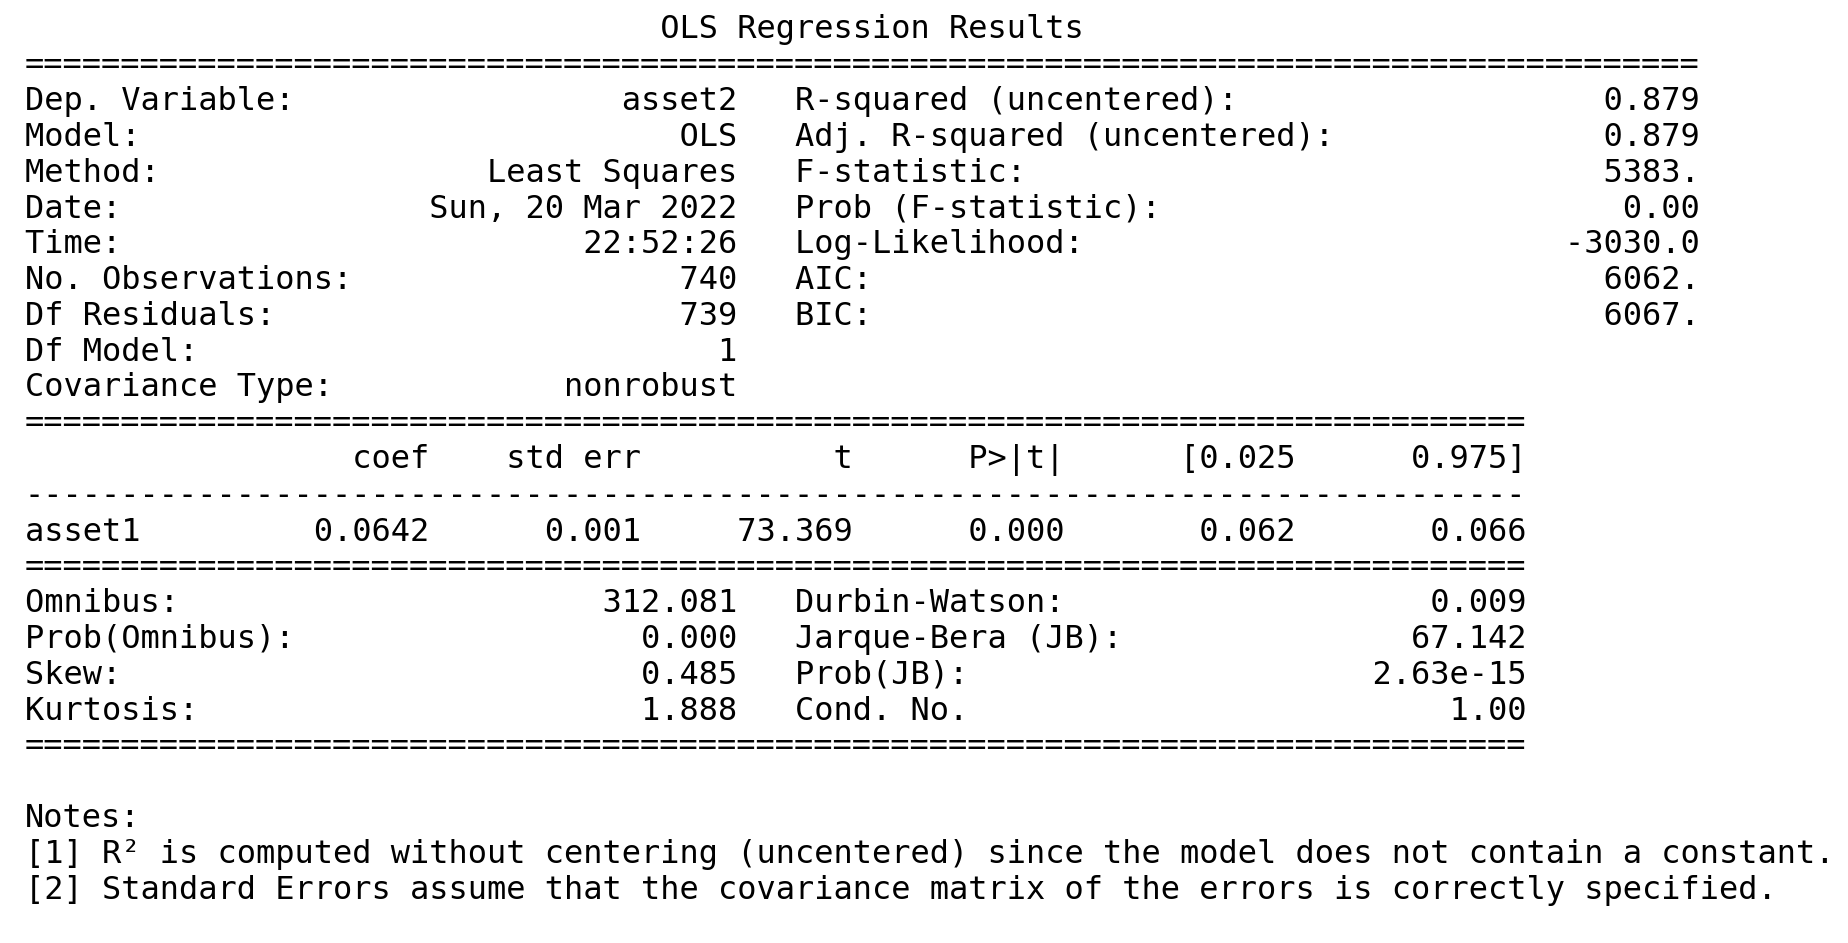

In [13]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [14]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  0.06416455762067452


In [15]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

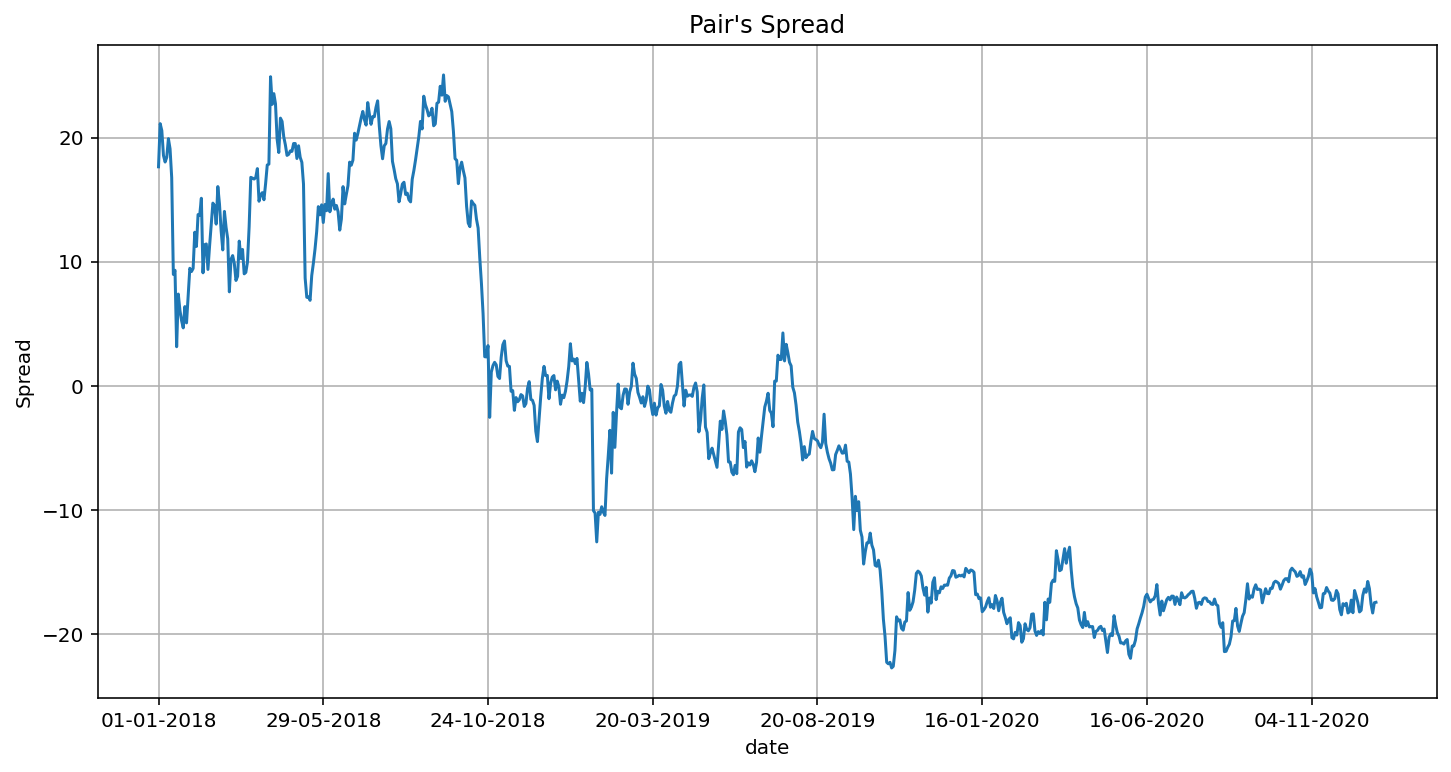

In [16]:
# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);
plt.savefig('chart5', dpi=400);

In [17]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-1.6605900353804204,
 0.45152343097132314,
 1,
 738,
 {'1%': -3.4392418578608983,
  '5%': -2.86546426916434,
  '10%': -2.568859710342903},
 2536.1368319615553)

In [18]:
print('Critical Value = ', adf[0])

Critical Value =  -1.6605900353804204


In [19]:
# probablity critical values
print(adf[4])

{'1%': -3.4392418578608983, '5%': -2.86546426916434, '10%': -2.568859710342903}


### Generate Trading Signals using z-score

In [20]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [21]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [22]:
signals.head()

asset1  asset2
date                          
01-01-2021  478.399994   13.40
04-01-2021  495.600006   13.05
05-01-2021  491.950012   12.85
06-01-2021  487.000000   12.75
07-01-2021  518.049988   12.80

In [23]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [24]:
signals.head()

asset1  asset2         z  z upper limit  z lower limit
date                                                                  
01-01-2021  478.399994   13.40 -0.212141            1.0           -1.0
04-01-2021  495.600006   13.05  0.094430            1.0           -1.0
05-01-2021  491.950012   12.85  0.135795            1.0           -1.0
06-01-2021  487.000000   12.75  0.123944            1.0           -1.0
07-01-2021  518.049988   12.80  0.430657            1.0           -1.0

In [25]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [26]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

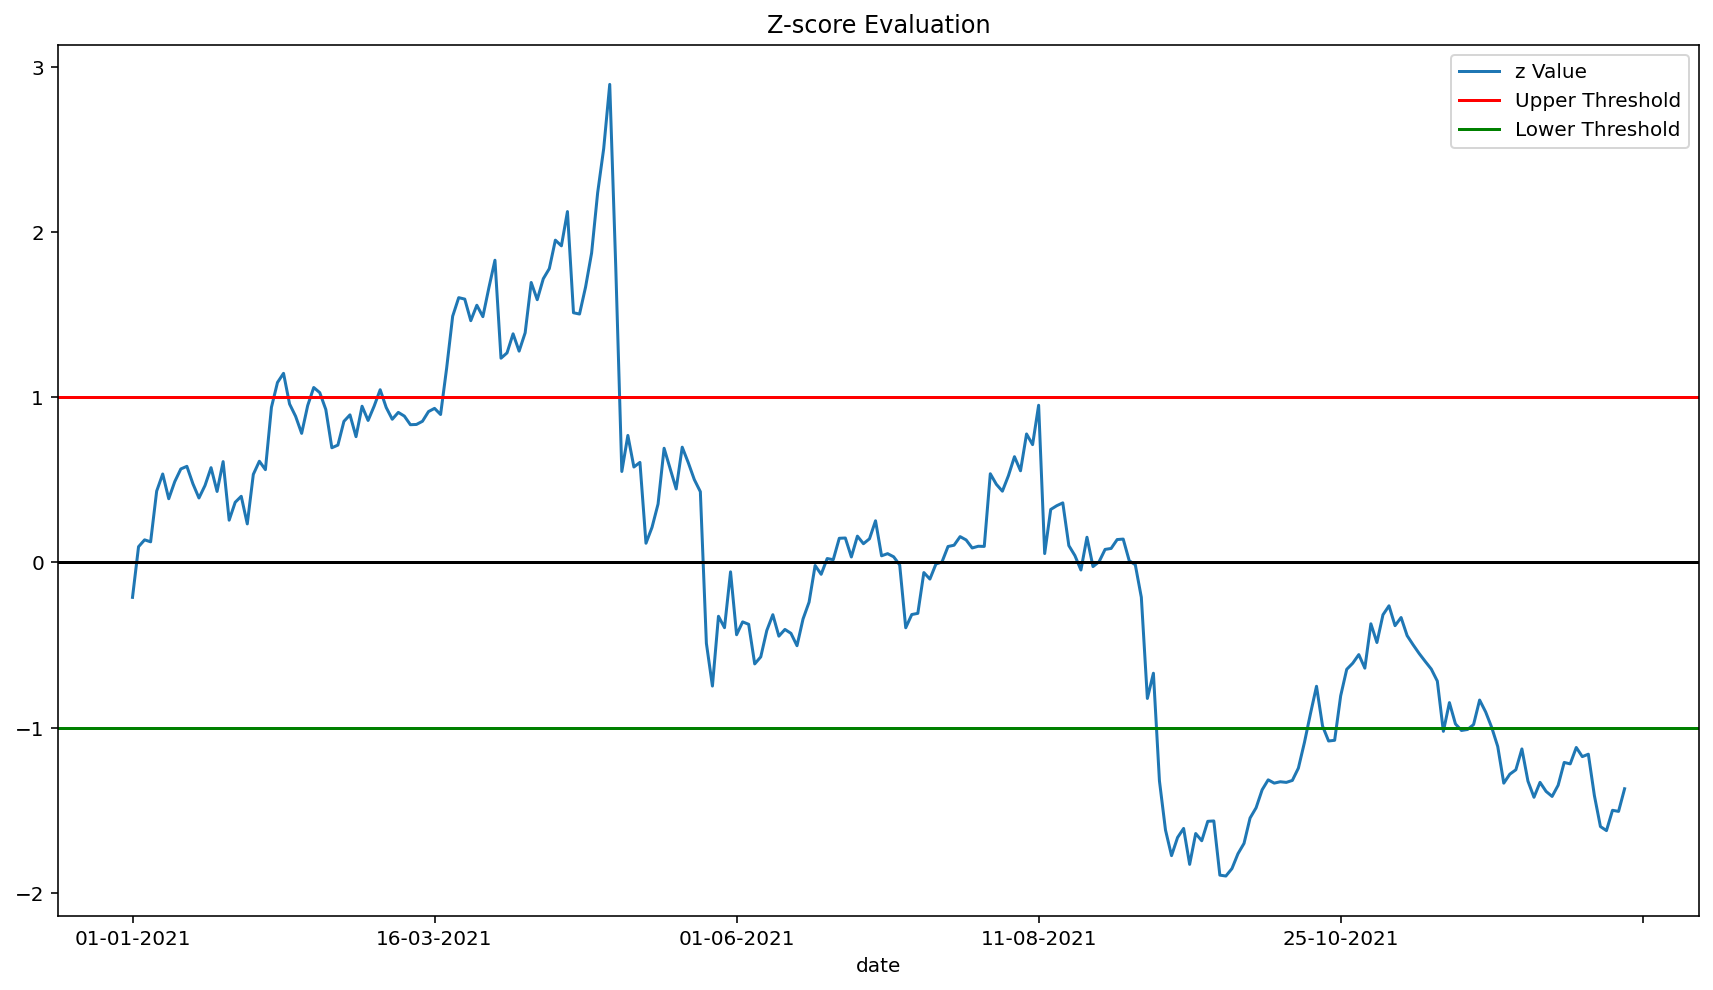

In [27]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value")
plt.title("Z-score Evaluation")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=400);

In [28]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1     asset2         z  z upper limit  z lower limit  \
date                                                                        
01-01-2021  478.399994  13.400000 -0.212141            1.0           -1.0   
04-01-2021  495.600006  13.050000  0.094430            1.0           -1.0   
05-01-2021  491.950012  12.850000  0.135795            1.0           -1.0   
29-12-2021  490.100006  18.750000 -1.500500            1.0           -1.0   
30-12-2021  487.850006  18.700001 -1.507295            1.0           -1.0   
31-12-2021  500.100006  18.450001 -1.370217            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
04-01-2021         0         0.0         0         0.0  
05-01-2021         0         0.0         0         0.0  
29-12-2021         1         0.0        -1         0.0  
30-12-2021         1         0.0        -1         0.0  
31-12-2021         1         0.0        -1         0.0

In [29]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1  asset2         z  z upper limit  z lower limit  \
date                                                                     
05-02-2021  553.299988   12.20  1.088093            1.0           -1.0   
08-02-2021  551.450012   12.05  1.143468            1.0           -1.0   
15-02-2021  518.950012   11.50  1.057595            1.0           -1.0   
16-02-2021  516.299988   11.50  1.026549            1.0           -1.0   
02-03-2021  513.299988   11.40  1.044153            1.0           -1.0   
18-03-2021  464.500000   10.10  1.173999            1.0           -1.0   
19-03-2021  478.450012    9.90  1.489013            1.0           -1.0   
22-03-2021  484.250000    9.85  1.601394            1.0           -1.0   
23-03-2021  481.149994    9.80  1.592570            1.0           -1.0   
24-03-2021  469.250000    9.75  1.462057            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
05-02-2021        -1        -1.0         1         1.0  
08-02-2021        -1         0.0         1         0.0  
15-02-2021        -1        -1.0         1         1.0  
16-02-2021        -1         0.0         1         0.0  
02-03-2021        -1        -1.0         1         1.0  
18-03-2021        -1        -1.0         1         1.0  
19-03-2021        -1         0.0         1         0.0  
22-03-2021        -1         0.0         1         0.0  
23-03-2021        -1         0.0         1         0.0  
24-03-2021        -1         0.0         1         0.0

In [30]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1     asset2         z  z upper limit  z lower limit  \
date                                                                        
01-01-2021  478.399994  13.400000 -0.212141            1.0           -1.0   
05-02-2021  553.299988  12.200000  1.088093            1.0           -1.0   
09-02-2021  528.200012  11.900000  0.957961            1.0           -1.0   
15-02-2021  518.950012  11.500000  1.057595            1.0           -1.0   
17-02-2021  525.250000  11.900000  0.924562            1.0           -1.0   
18-11-2021  538.750000  18.150000 -1.022961            1.0           -1.0   
22-11-2021  540.500000  17.450001 -0.849028            1.0           -1.0   
24-11-2021  536.500000  18.049999 -1.017599            1.0           -1.0   
26-11-2021  523.299988  17.450001 -0.981823            1.0           -1.0   
02-12-2021  533.650024  18.400000 -1.114638            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
05-02-2021        -1        -1.0         1         1.0  
09-02-2021         0         1.0         0        -1.0  
15-02-2021        -1        -1.0         1         1.0  
17-02-2021         0         1.0         0        -1.0  
18-11-2021         1         1.0        -1        -1.0  
22-11-2021         0        -1.0         0         1.0  
24-11-2021         1         1.0        -1        -1.0  
26-11-2021         0        -1.0         0         1.0  
02-12-2021         1         1.0        -1        -1.0

In [31]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

528.200012    1
525.250000    1
506.399994    1
490.049988    1
491.450012    1
549.900024    1
538.750000    1
536.500000    1
533.650024    1
Name: asset1, dtype: int64

In [32]:
signals

asset1     asset2         z  z upper limit  z lower limit  \
date                                                                        
01-01-2021  478.399994  13.400000 -0.212141            1.0           -1.0   
04-01-2021  495.600006  13.050000  0.094430            1.0           -1.0   
05-01-2021  491.950012  12.850000  0.135795            1.0           -1.0   
06-01-2021  487.000000  12.750000  0.123944            1.0           -1.0   
07-01-2021  518.049988  12.800000  0.430657            1.0           -1.0   
...                ...        ...       ...            ...            ...   
27-12-2021  489.100006  19.250000 -1.598968            1.0           -1.0   
28-12-2021  491.899994  19.500000 -1.623508            1.0           -1.0   
29-12-2021  490.100006  18.750000 -1.500500            1.0           -1.0   
30-12-2021  487.850006  18.700001 -1.507295            1.0           -1.0   
31-12-2021  500.100006  18.450001 -1.370217            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
04-01-2021         0         0.0         0         0.0  
05-01-2021         0         0.0         0         0.0  
06-01-2021         0         0.0         0         0.0  
07-01-2021         0         0.0         0         0.0  
...              ...         ...       ...         ...  
27-12-2021         1         0.0        -1         0.0  
28-12-2021         1         0.0        -1         0.0  
29-12-2021         1         0.0        -1         0.0  
30-12-2021         1         0.0        -1         0.0  
31-12-2021         1         0.0        -1         0.0  

[248 rows x 9 columns]

In [33]:
signals = signals.reset_index()

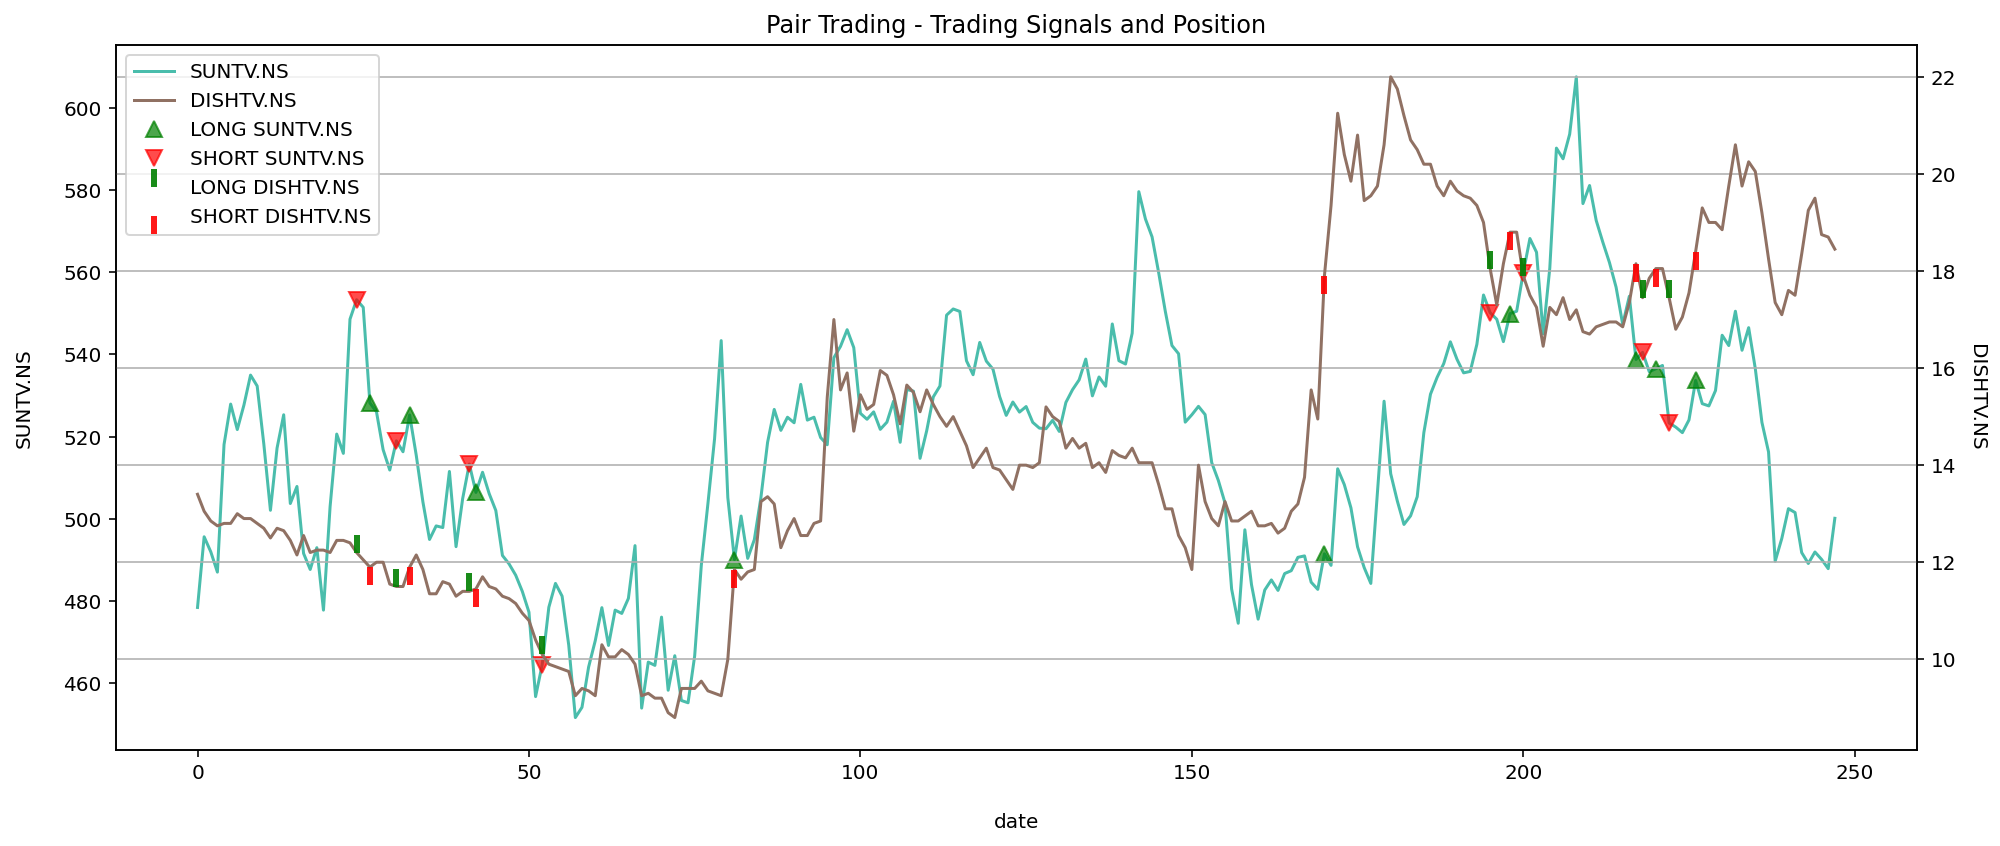

In [34]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=400);

### Portfolio Profit and Loss Calculation

In [35]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [36]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [37]:
portfolio.head().append(portfolio.tail())

asset1  holdings1          cash1   total asset1   return1  positions1
0    478.399994        NaN            NaN            NaN       NaN         NaN
1    495.600006      0.000  100000.000000  100000.000000       NaN         0.0
2    491.950012      0.000  100000.000000  100000.000000  0.000000         0.0
3    487.000000      0.000  100000.000000  100000.000000  0.000000         0.0
4    518.049988      0.000  100000.000000  100000.000000  0.000000         0.0
243  489.100006  80212.401   21894.994998  102107.395998 -0.004238         0.0
244  491.899994  80671.599   21894.994998  102566.593998  0.004497         0.0
245  490.100006  80376.401   21894.994998  102271.395998 -0.002878         0.0
246  487.850006  80007.401   21894.994998  101902.395998 -0.003608         0.0
247  500.100006  82016.401   21894.994998  103911.395998  0.019715         0.0

In [38]:
portfolio[portfolio.positions1 != 0].head()

asset1     holdings1          cash1   total asset1       return1  \
0   478.399994           NaN            NaN            NaN           NaN   
24  553.299988 -90741.197999  190741.197999  100000.000000  2.220446e-16   
26  528.200012      0.000000  104116.395998  104116.395998  3.801467e-02   
30  518.950012 -85107.802001  189224.197999  104116.395998  2.220446e-16   
32  525.250000      0.000000  103083.197999  103083.197999 -1.403910e-02   

    positions1  
0          NaN  
24        -1.0  
26         1.0  
30        -1.0  
32         1.0

In [39]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [40]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1  holdings1          cash1   total asset1   return1  \
0    478.399994        NaN            NaN            NaN       NaN   
1    495.600006      0.000  100000.000000  100000.000000       NaN   
2    491.950012      0.000  100000.000000  100000.000000  0.000000   
3    487.000000      0.000  100000.000000  100000.000000  0.000000   
4    518.049988      0.000  100000.000000  100000.000000  0.000000   
243  489.100006  80212.401   21894.994998  102107.395998 -0.004238   
244  491.899994  80671.599   21894.994998  102566.593998  0.004497   
245  490.100006  80376.401   21894.994998  102271.395998 -0.002878   
246  487.850006  80007.401   21894.994998  101902.395998 -0.003608   
247  500.100006  82016.401   21894.994998  103911.395998  0.019715   

     positions1     asset2     holdings2          cash2   total asset2  \
0           NaN  13.400000           NaN            NaN            NaN   
1           0.0  13.050000      0.000000  100000.000000  100000.000000   
2           0.0  12.850000      0.000000  100000.000000  100000.000000   
3           0.0  12.750000      0.000000  100000.000000  100000.000000   
4           0.0  12.800000      0.000000  100000.000000  100000.000000   
243         0.0  19.250000 -87491.250000  201580.734456  114089.484456   
244         0.0  19.500000 -88627.500000  201580.734456  112953.234456   
245         0.0  18.750000 -85218.750000  201580.734456  116361.984456   
246         0.0  18.700001 -84991.503454  201580.734456  116589.231002   
247         0.0  18.450001 -83855.253454  201580.734456  117725.481002   

      return2  positions2  
0         NaN         NaN  
1         NaN         0.0  
2    0.000000         0.0  
3    0.000000         0.0  
4    0.000000         0.0  
243 -0.034612         0.0  
244 -0.009959         0.0  
245  0.030178         0.0  
246  0.001953         0.0  
247  0.009746         0.0

In [41]:
portfolio[portfolio.positions2 != 0].head()

asset1     holdings1          cash1   total asset1       return1  \
0   478.399994           NaN            NaN            NaN           NaN   
24  553.299988 -90741.197999  190741.197999  100000.000000  2.220446e-16   
26  528.200012      0.000000  104116.395998  104116.395998  3.801467e-02   
30  518.950012 -85107.802001  189224.197999  104116.395998  2.220446e-16   
32  525.250000      0.000000  103083.197999  103083.197999 -1.403910e-02   

    positions1  asset2     holdings2          cash2   total asset2   return2  \
0          NaN    13.4           NaN            NaN            NaN       NaN   
24        -1.0    12.2  55448.999136   44551.000864  100000.000000  0.000000   
26         1.0    11.9      0.000000   98636.499136   98636.499136 -0.006864   
30        -1.0    11.5  52267.500000   46368.999136   98636.499136  0.000000   
32         1.0    11.9      0.000000  100454.497409  100454.497409  0.018431   

    positions2  
0          NaN  
24         1.0  
26        -1.0  
30         1.0  
32        -1.0

In [42]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

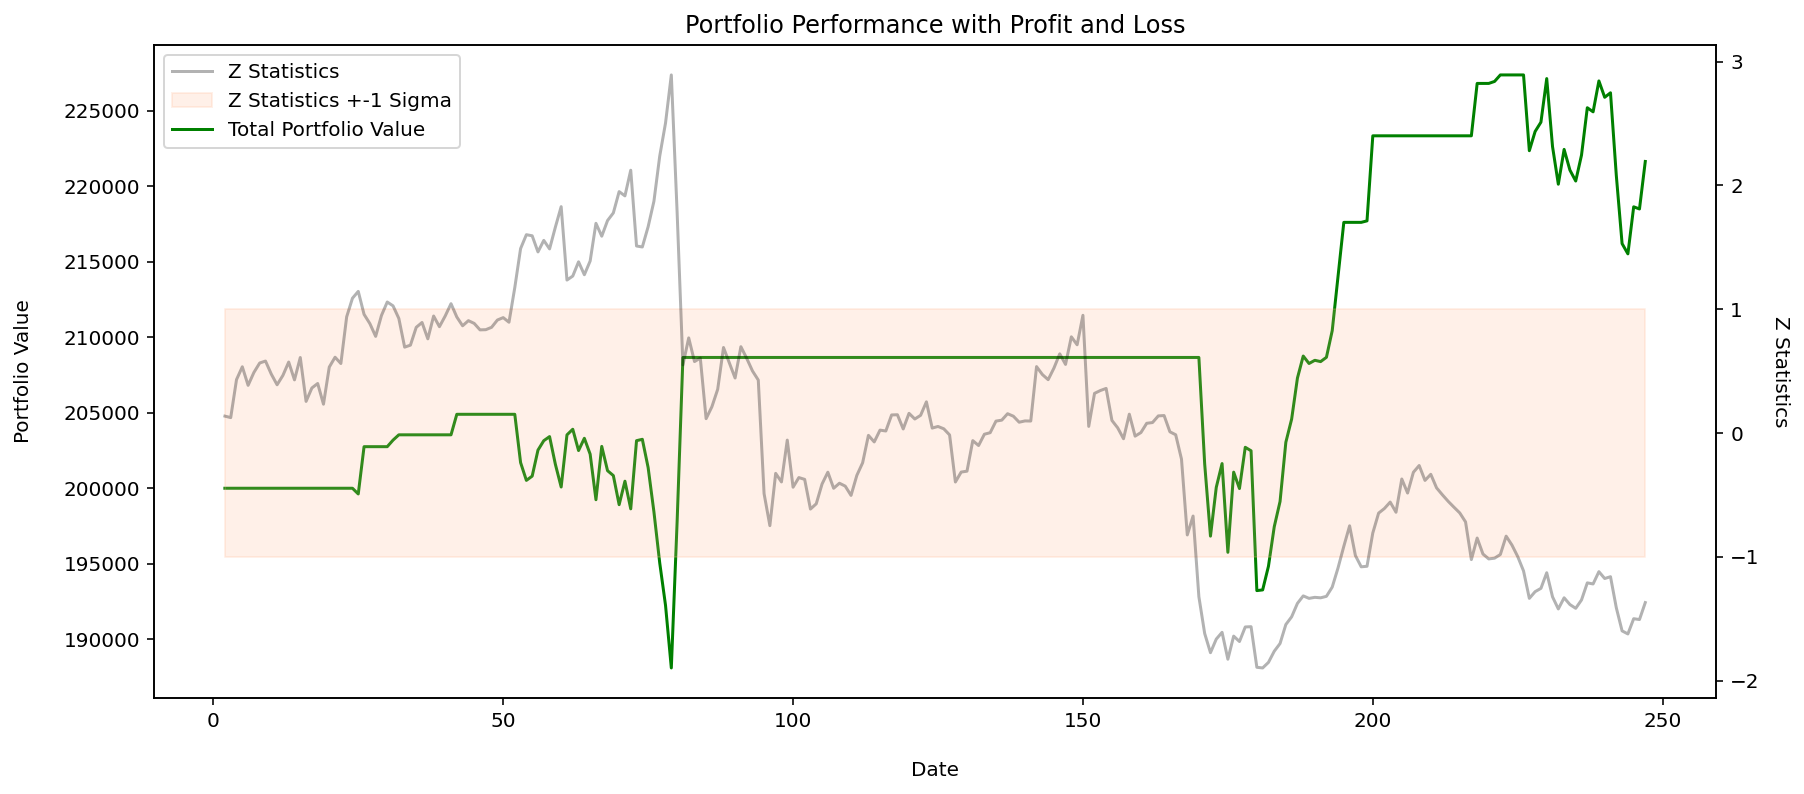

In [43]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('chart8', dpi=400);

In [44]:
#portfolio = pd.read_csv('portfolio.csv')

In [45]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

221636.87700029998

In [46]:
profit = final_portfolio - 2*initial_capital
profit

21636.87700029998

In [47]:
roi = (profit/(2*initial_capital))*100
roi

10.818438500149991

In [ ]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

In [45]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 227.293%
